<a href="https://colab.research.google.com/github/z-gard/analysis/blob/main/notebooks/medical_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 医療スコア
- input
    - hospital_master.cav
        - 病院の位置とレーティング
    - pharmacy_nearby.csv
        - 薬局の位置とレーティング
- output
    - mecical_score.csv
        - 医療スコア

In [1]:
!pip install -q japanize-matplotlib

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import requests
import json
import pandas as pd
from urllib.parse import urlparse, quote
import io
import math
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

In [4]:
DIR_NAME = '/content/drive/MyDrive/z-gard/data'

In [5]:
output_score_file = 'medical_score.csv'

### 病院

In [6]:
df_hospital_master = pd.read_csv(os.path.join(DIR_NAME, 'hospital_master.csv'))[['名称', '小児', '妊婦', '緯度', '経度', 'rating']]
df_hospital_master['施設分類'] = '病院'
print(df_hospital_master.shape)

(3571, 7)


In [7]:
df_hospital_master.head()

,名称,小児,妊婦,緯度,経度,rating,施設分類
0,メディカクリニック,1.0,1.0,35.694355,139.762639,3.6,病院
1,九段坂内科消化器内科クリニック,NaN,NaN,35.696069,139.754469,4.2,病院
2,医療法人社団平晴会晴海3丁目クリニック,NaN,NaN,35.654056,139.779257,4.7,病院
3,文京春日こどもクリニック,2.0,NaN,35.710461,139.752461,4.2,病院
4,蔵前まえだクリニック,NaN,NaN,35.706362,139.789713,4.6,病院


### 薬局

In [8]:
df_pharmacy_master = pd.read_csv(os.path.join(DIR_NAME, 'pharmacy_nearby.csv'))[
    ['name', 'lat', 'lng', 'rating']
].rename(columns={'lat':'緯度', 'lng':'経度'})
df_pharmacy_master['施設分類'] = '薬局'
print(df_pharmacy_master.shape)

(5980, 5)


In [9]:
df_pharmacy_master.head()

,name,緯度,経度,rating,施設分類
0,日本調剤㈱,35.681553,139.769161,2.5,薬局
1,アイン薬局 グランスタ丸の内店,35.682737,139.766298,4.0,薬局
2,ココカラファイン ヤエチカ北口店,35.681502,139.769801,3.1,薬局
3,ココカラファイン薬局 ヤエチカ北口店,35.681495,139.769810,3.7,薬局
4,ウエルシア東京ミッドタウン八重洲店 (調剤薬局),35.679466,139.769185,3.0,薬局


### 人口マスタ

In [10]:
df_pop_master = pd.read_csv(os.path.join(DIR_NAME, 'population_master.csv'))[['地域ID', '市区町村名', '町名', '町丁目', '緯度', '経度']]
print(df_pop_master.shape)

(3145, 6)


In [11]:
# 距離計算
def get_distance(lat1, lon1, lat2, lon2):
    _lat1 = lat1 * math.pi / 180
    _lon1 = lon1 * math.pi / 180
    _lat2 = lat2 * math.pi / 180
    _lon2 = lon2 * math.pi / 180
    _tmp = math.cos(_lat1) * math.cos(_lat2) * math.cos(_lon2 - _lon1) + math.sin(_lat1) * math.sin(_lat2)
    _tmp = 1 if _tmp > 1 else -1 if _tmp < -1 else _tmp
    return 6371 * math.acos(_tmp)

# 最寄り施設までの距離
def get_value_of_nearest_facility(df_master, df_facility, category, method='min', param=3):
    _df_cat = df_facility[df_facility['施設分類'] == category].copy()
    cat_values = []
    for i, row in df_master.iterrows():
        dist = _df_cat.apply(lambda x: get_distance(x['緯度'], x['経度'], row['緯度'], row['経度']), axis=1)
        val = None
        if method == 'min':
            # 最小の距離
            val = dist.min()
        elif method == 'count':
            # {param}km以内の施設の数をカウント
            val = len(dist[dist <= param])
        elif method == 'mean':
            # 近い{param}件の距離の平均
            val = dist.sort_values()[:param].mean()
        cat_values.append(val)
    return cat_values

In [12]:
def normalize_score(sr_data, high=True, outlier=True):
    score = (sr_data - sr_data.mean())/sr_data.std()
    score = score if high else -score

    if outlier:
        high_s = score.quantile(0.99)
        low_s = score.quantile(0.01)
        score[score > high_s] = high_s
        score[score < low_s] = low_s
    else:
        high_s = score.max()
        low_s = score.min()
        
    return (score - low_s)/(high_s - low_s)


def rank_score(sr_data):
    size = sr_data.notna().sum()
    rank = sr_data.rank()
    result = rank.copy()
    # 0~1: 15%, 1~2: 20%, 2~3: 30%, 3~4: 20%, 4~5: 15%
    level_list = [0.15, (0.15+0.2), (0.15+0.2+0.3), (0.15+0.2+0.3+0.2), 1]
    
    pre_level = 0
    for index, level in enumerate([lv*size for lv in level_list]):
        result[(rank > pre_level)&(rank <= level)] = (rank - pre_level)/(level - pre_level) + index
        pre_level = level

    return result

## 医療スコア

In [13]:
%%time
# 近い3件の距離の平均
df_pop_master['病院(平均距離)'] = get_value_of_nearest_facility(df_pop_master, df_hospital_master, '病院', 'mean', 3)
# 1km以内の施設の数
df_pop_master['病院(数)'] = get_value_of_nearest_facility(df_pop_master, df_hospital_master, '病院', 'count', 1)
# 一番近い施設の距離
df_pop_master['小児病院(最近傍距離)'] = get_value_of_nearest_facility(df_pop_master, df_hospital_master[df_hospital_master['小児'].notna()], '病院', 'min')

# 近い3件の距離の平均
df_pop_master['薬局(平均距離)'] = get_value_of_nearest_facility(df_pop_master, df_pharmacy_master, '薬局', 'mean', 3)
# 1km以内の施設の数
df_pop_master['薬局(数)'] = get_value_of_nearest_facility(df_pop_master, df_pharmacy_master, '薬局', 'count', 1)

CPU times: user 24min 38s, sys: 3.28 s, total: 24min 41s
Wall time: 24min 49s


In [14]:
print(df_pop_master.shape)
df_pop_master.head()

(3145, 11)


,地域ID,市区町村名,町名,町丁目,緯度,経度,病院(平均距離),病院(数),小児病院(最近傍距離),薬局(平均距離),薬局(数)
0,101003,千代田区,丸の内,丸の内１丁目,35.681610,139.767511,0.218947,43,0.163731,0.174293,68
1,101004,千代田区,丸の内,丸の内２丁目,35.680071,139.763944,0.407812,41,0.334319,0.314846,52
2,101005,千代田区,丸の内,丸の内３丁目,35.676890,139.764039,0.224647,47,0.293196,0.201197,70
3,101007,千代田区,大手町,大手町１丁目,35.688067,139.764353,0.125300,34,0.196350,0.087895,69
4,101008,千代田区,大手町,大手町２丁目,35.686416,139.768530,0.231311,34,0.390825,0.177948,78


In [15]:
score_name = '医療スコア'
feature_list = {
    '病院(平均距離)':       {'high': False, 'outlier': True, 'weight': 1}, 
    '病院(数)':             {'high': True, 'outlier': True, 'weight': 1},
    '小児病院(最近傍距離)': {'high': False, 'outlier': True, 'weight': 0.8}, 
    '薬局(平均距離)':       {'high': False, 'outlier': True, 'weight': 0.5}, 
    '薬局(数)':             {'high': True, 'outlier': True, 'weight': 0.5}, 
}

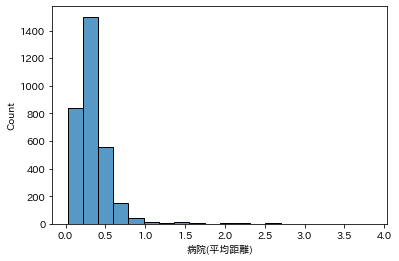

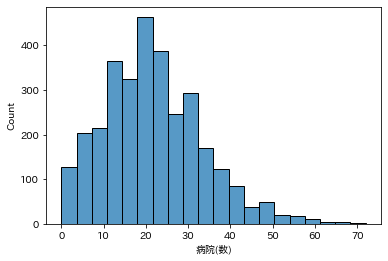

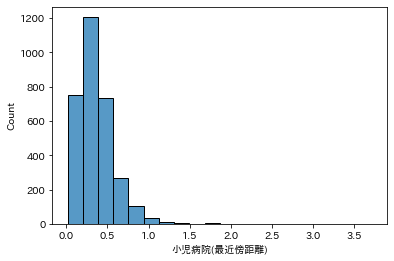

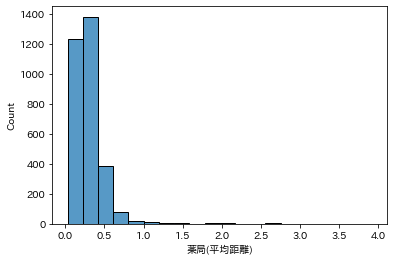

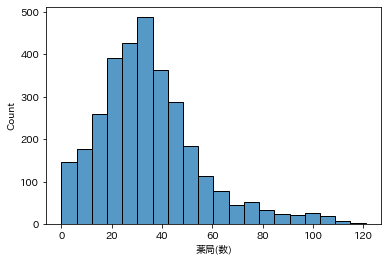

In [16]:
for feature_name in feature_list.keys():
    sns.histplot(df_pop_master[feature_name], bins=20)
    plt.show()

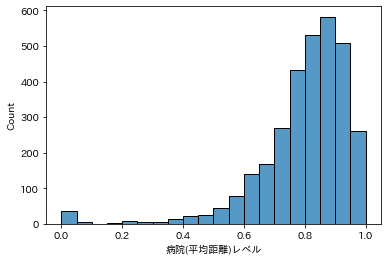

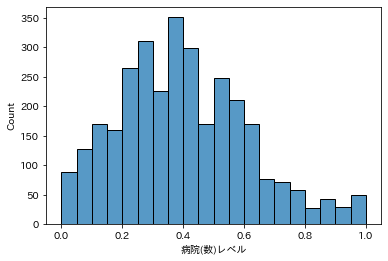

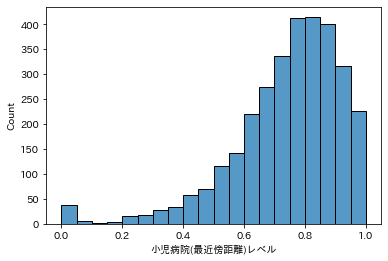

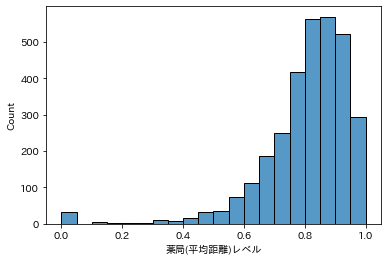

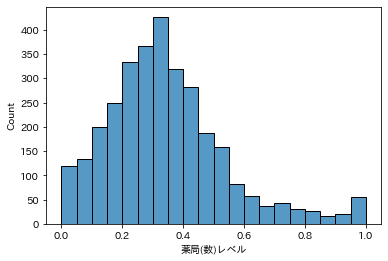

In [17]:
for key, value in feature_list.items():
    df_pop_master[f'{key}レベル'] = normalize_score(df_pop_master[key], high=value['high'], outlier=value['outlier'])
    sns.histplot(df_pop_master[f'{key}レベル'], bins=20)
    plt.show()

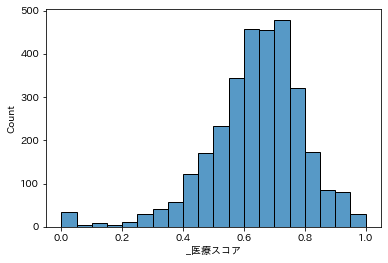

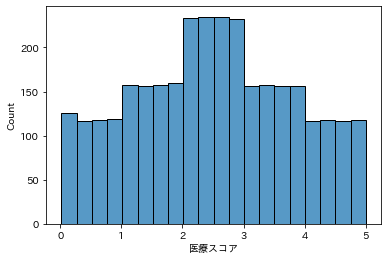

In [18]:
score_list = []
for key, value in feature_list.items():
    score_list.append(df_pop_master[f'{key}レベル'] * value['weight'])

score_sub_name = '_' + score_name
df_pop_master[score_sub_name] = normalize_score(pd.concat(score_list, axis=1).sum(axis=1, skipna=False), outlier=False)
df_pop_master[score_name] = rank_score(df_pop_master[score_sub_name])

total_score_list = [score_sub_name, score_name]
for _score in total_score_list:
    sns.histplot(df_pop_master[_score], bins=20)
    plt.show()

In [19]:
df_pop_master.head()

,地域ID,市区町村名,町名,町丁目,緯度,経度,病院(平均距離),病院(数),小児病院(最近傍距離),薬局(平均距離),薬局(数),病院(平均距離)レベル,病院(数)レベル,小児病院(最近傍距離)レベル,薬局(平均距離)レベル,薬局(数)レベル,_医療スコア,医療スコア
0,101003,千代田区,丸の内,丸の内１丁目,35.681610,139.767511,0.218947,43,0.163731,0.174293,68,0.892587,0.796296,0.901390,0.903115,0.666667,0.864693,4.662528
1,101004,千代田区,丸の内,丸の内２丁目,35.680071,139.763944,0.407812,41,0.334319,0.314846,52,0.746683,0.759259,0.764052,0.786399,0.509804,0.748422,3.640481
2,101005,千代田区,丸の内,丸の内３丁目,35.676890,139.764039,0.224647,47,0.293196,0.201197,70,0.888184,0.870370,0.797159,0.880774,0.686275,0.860611,4.643426
3,101007,千代田区,大手町,大手町１丁目,35.688067,139.764353,0.125300,34,0.196350,0.087895,69,0.964932,0.629630,0.875129,0.974862,0.676471,0.844514,4.558527
4,101008,千代田区,大手町,大手町２丁目,35.686416,139.768530,0.231311,34,0.390825,0.177948,78,0.883035,0.629630,0.718559,0.900081,0.764706,0.790270,4.127666


In [20]:
df_pop_master[
    ['地域ID', '市区町村名', '町丁目'] + list(feature_list.keys()) + total_score_list
].to_csv(os.path.join(DIR_NAME, output_score_file), index=False)

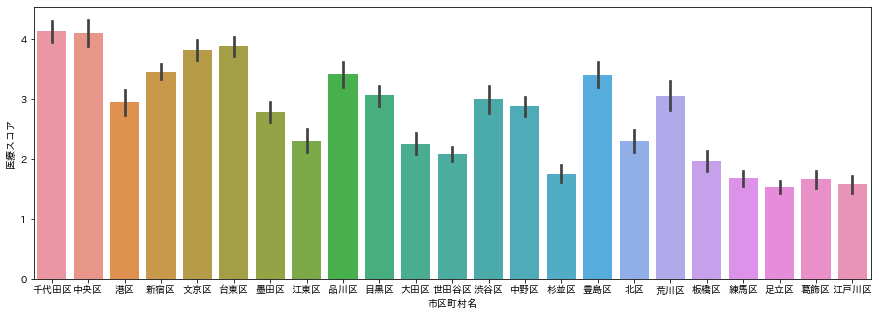

In [21]:
plt.figure(figsize=(15, 5))
sns.barplot(x='市区町村名', y=score_name, data=df_pop_master)
plt.show()

In [22]:
df_library_level = df_pop_master.copy()
df_library_level['rank'] = df_library_level.groupby('町名')[score_name].transform('rank', ascending=False)
df_library_level = df_library_level[df_library_level['rank'] == 1].sort_values(score_name, ascending=False)[
    ['市区町村名', '町名', '町丁目'] + total_score_list + list(feature_list.keys())
].reset_index(drop=True)
print(df_library_level.shape)

(908, 10)


In [23]:
df_library_level.head(20)

,市区町村名,町名,町丁目,_医療スコア,医療スコア,病院(平均距離),病院(数),小児病院(最近傍距離),薬局(平均距離),薬局(数)
0,中央区,日本橋小伝馬町,日本橋小伝馬町,1.000000,5.000000,0.076007,57,0.159427,0.127615,105
1,千代田区,神田鍛冶町,神田鍛冶町３丁目,0.999968,4.997878,0.133395,51,0.040381,0.077895,106
2,中央区,銀座,銀座２丁目,0.993287,4.995755,0.104753,60,0.115384,0.114995,94
3,中央区,京橋,京橋２丁目,0.988681,4.993633,0.111423,59,0.097616,0.076689,86
4,千代田区,内神田,内神田２丁目,0.987998,4.991510,0.112811,50,0.048005,0.073180,94
5,千代田区,神田多町,神田多町２丁目,0.980669,4.987265,0.106774,50,0.149220,0.087081,107
6,千代田区,有楽町,有楽町１丁目,0.978219,4.983020,0.058988,58,0.030563,0.067936,65
7,千代田区,鍛冶町,鍛冶町１丁目,0.975356,4.980898,0.078775,51,0.216878,0.088575,99
8,港区,西新橋,西新橋１丁目,0.968121,4.974530,0.098831,57,0.174731,0.116225,82
9,港区,新橋,新橋１丁目,0.966627,4.970285,0.092797,69,0.289063,0.093267,93


In [24]:
df_library_level.tail(20)

,市区町村名,町名,町丁目,_医療スコア,医療スコア,病院(平均距離),病院(数),小児病院(最近傍距離),薬局(平均距離),薬局(数)
888,大田区,平和島,平和島１丁目,0.362293,0.318370,0.724472,9,0.784415,0.623107,17
889,足立区,六木,六木１丁目,0.361961,0.316247,0.996004,1,0.197166,0.521505,4
890,世田谷区,宇奈根,宇奈根３丁目,0.359584,0.307758,0.965244,1,0.231144,0.547185,4
891,大田区,羽田旭町,羽田旭町,0.358690,0.305635,0.781114,6,0.679312,0.531793,13
892,足立区,神明南,神明南１丁目,0.352687,0.286533,0.762324,8,0.753177,0.559377,10
893,江戸川区,下篠崎町,下篠崎町,0.339951,0.261063,0.548123,2,1.017577,0.358088,7
894,世田谷区,玉堤,玉堤１丁目,0.336956,0.252573,0.878922,1,0.391284,0.648939,3
895,江東区,青海,青海１丁目,0.328578,0.239839,0.554338,3,0.592112,1.081474,1
896,江戸川区,東篠崎,東篠崎２丁目,0.325261,0.233471,0.735482,5,0.898327,0.565250,16
897,渋谷区,代々木神園町,代々木神園町,0.324022,0.229226,0.805465,7,0.835845,0.691218,21
